In [ ]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

In [ ]:
#!pip install pyspark

     |████████████████████████████████| 281.3 MB 29 kB/s 
     |████████████████████████████████| 198 kB 61.4 MB/s 
  Created wheel for pyspark: filename=pyspark-3.2.0-py2.py3-none-any.whl size=281805911 sha256=531305b01f5f2bc271a63ce8acfb1f3248197ac9d35f75a53d126fa510950e27
  Stored in directory: /root/.cache/pip/wheels/0b/de/d2/9be5d59d7331c6c2a7c1b6d1a4f463ce107332b1ecd4e80718
Successfully built pyspark


In [ ]:
import pyspark

In [ ]:
from pyspark.sql import SparkSession
spark = SparkSession.builder.appName('Water Potability').getOrCreate() # session name
spark

In [ ]:
from google.colab import drive
drive.mount("/content/gdrive")

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


In [ ]:
df = pd.read_csv('/content/gdrive/MyDrive/Year 3 Sem 1/WIH3003 Big Data Applications/water_potability.csv')

In [ ]:
df = pd.concat([df]*512)

In [ ]:
df.shape

(1677312, 10)

In [ ]:
df = spark.createDataFrame(df)
df.show()

+------------------+------------------+------------------+------------------+------------------+------------------+------------------+------------------+------------------+----------+
|                ph|          Hardness|            Solids|       Chloramines|           Sulfate|      Conductivity|    Organic_carbon|   Trihalomethanes|         Turbidity|Potability|
+------------------+------------------+------------------+------------------+------------------+------------------+------------------+------------------+------------------+----------+
|               NaN|204.89045547133634|20791.318980747023| 7.300211873184757| 368.5164413498034| 564.3086541722439|  10.3797830780847|  86.9909704615088|2.9631353806316407|         0|
|3.7160800753869903|129.42292051494422| 18630.05785797035|    6.635245883862|               NaN| 592.8853591348523| 15.18001311635726| 56.32907628451764| 4.500656274942409|         0|
| 8.099124189298397|224.23625939355773|19909.541732292397| 9.275883602694089|   

In [ ]:
df.dtypes

[('ph', 'double'),
 ('Hardness', 'double'),
 ('Solids', 'double'),
 ('Chloramines', 'double'),
 ('Sulfate', 'double'),
 ('Conductivity', 'double'),
 ('Organic_carbon', 'double'),
 ('Trihalomethanes', 'double'),
 ('Turbidity', 'double'),
 ('Potability', 'bigint')]

## Data Cleaning

Check for null values

In [ ]:
from pyspark.sql.functions import isnan, when, count, col
df.select([count(when(isnan(c), c)).alias(c) for c in df.columns]).show()

+------+--------+------+-----------+-------+------------+--------------+---------------+---------+----------+
|    ph|Hardness|Solids|Chloramines|Sulfate|Conductivity|Organic_carbon|Trihalomethanes|Turbidity|Potability|
+------+--------+------+-----------+-------+------------+--------------+---------------+---------+----------+
|251392|       0|     0|          0| 399872|           0|             0|          82944|        0|         0|
+------+--------+------+-----------+-------+------------+--------------+---------------+---------+----------+



In [ ]:
num_cols = [col_type[0] for col_type in filter(lambda dtype: dtype[1] in {"bigint", "double", "int"}, df.dtypes)]

median_dict = dict()
for c in num_cols:
   median_dict[c] = df.stat.approxQuantile(c, [0.5], 0.001)[0]

In [ ]:
df = df.na.fill(median_dict)
df.show()

+------------------+------------------+------------------+------------------+------------------+------------------+------------------+------------------+------------------+----------+
|                ph|          Hardness|            Solids|       Chloramines|           Sulfate|      Conductivity|    Organic_carbon|   Trihalomethanes|         Turbidity|Potability|
+------------------+------------------+------------------+------------------+------------------+------------------+------------------+------------------+------------------+----------+
| 7.035036795196813|204.89045547133634|20791.318980747023| 7.300211873184757| 368.5164413498034| 564.3086541722439|  10.3797830780847|  86.9909704615088|2.9631353806316407|         0|
|3.7160800753869903|129.42292051494422| 18630.05785797035|    6.635245883862|  333.073364224501| 592.8853591348523| 15.18001311635726| 56.32907628451764| 4.500656274942409|         0|
| 8.099124189298397|224.23625939355773|19909.541732292397| 9.275883602694089|  3

In [ ]:
from pyspark.sql.functions import isnan, when, count, col
df.select([count(when(isnan(c), c)).alias(c) for c in df.columns]).show()

+---+--------+------+-----------+-------+------------+--------------+---------------+---------+----------+
| ph|Hardness|Solids|Chloramines|Sulfate|Conductivity|Organic_carbon|Trihalomethanes|Turbidity|Potability|
+---+--------+------+-----------+-------+------------+--------------+---------------+---------+----------+
|  0|       0|     0|          0|      0|           0|             0|              0|        0|         0|
+---+--------+------+-----------+-------+------------+--------------+---------------+---------+----------+



Feature Engineering

In [ ]:
from pyspark.sql.functions import when, lit
df = df.withColumn("Type of Water", \
     when((df.ph > 9), lit("Alkaline water")) \
       .when((df.ph <= 9) & (df.ph > 8), lit("Bottled waters labeled as alkaline")) \
       .when((df.ph <= 8) & (df.ph > 7.5), lit("Ocean water")) \
       .when((df.ph == 7.5 ), lit("Tap water")) \
       .when((df.ph < 7.5) & (df.ph >= 6.5), lit("Common bottled waters")) \
       .when((df.ph < 6.5) & (df.ph >= 5.5), lit("Distilled reverse osmosis wate")) \
       .otherwise(lit("Acidic water")) \
      )

In [ ]:
df = df.withColumn("Type of Hardness", \
     when((df.Hardness >= 0) & (df.Hardness < 17.1), lit("Soft")) \
       .when((df.Hardness >= 17.1) & (df.Hardness < 60), lit("Slightly hard")) \
       .when((df.Hardness >= 60) & (df.Hardness < 120), lit("Moderately hard")) \
       .when((df.Hardness >= 120) & (df.Hardness < 180), lit("Hard")) \
       .otherwise(lit("Very Hard")) \
    )

In [ ]:
df.show()

+------------------+------------------+------------------+------------------+------------------+------------------+------------------+------------------+------------------+----------+--------------------+----------------+
|                ph|          Hardness|            Solids|       Chloramines|           Sulfate|      Conductivity|    Organic_carbon|   Trihalomethanes|         Turbidity|Potability|       Type of Water|Type of Hardness|
+------------------+------------------+------------------+------------------+------------------+------------------+------------------+------------------+------------------+----------+--------------------+----------------+
| 7.035036795196813|204.89045547133634|20791.318980747023| 7.300211873184757| 368.5164413498034| 564.3086541722439|  10.3797830780847|  86.9909704615088|2.9631353806316407|         0|Common bottled wa...|       Very Hard|
|3.7160800753869903|129.42292051494422| 18630.05785797035|    6.635245883862|  333.073364224501| 592.88535913485

## String Indexing, One Hot Encoding, Vector Assembling

*   String Indexing: convert each categories in every categorical column into numerical type
*   One Hot Encoding: separate each category into a vector column
*   Vector Assembling: assemble each features into a single vector column



In [ ]:
from pyspark.ml.feature import StringIndexer
from pyspark.ml.feature import OneHotEncoder
from pyspark.ml.feature import VectorAssembler
from pyspark.ml import Pipeline

stages = []
numerical_columns = ['ph', 'Hardness', 'Solids', 'Chloramines', 'Sulfate', 'Conductivity', 'Organic_carbon', 'Trihalomethanes', 'Turbidity']
categorical_columns= ['Type of Water','Type of Hardness']

for categoricalCol in categorical_columns:
    stringIndexer = StringIndexer(inputCol = categoricalCol, outputCol = categoricalCol + ' Index')
    encoder = OneHotEncoder(inputCols=[stringIndexer.getOutputCol()], outputCols=[categoricalCol + " OHE"])
    stages += [stringIndexer, encoder]

label_string_idx = StringIndexer(inputCol = 'Potability', outputCol = 'label')
stages.append(label_string_idx)

assemblerInputs = [c + " OHE" for c in categorical_columns] + numerical_columns
assembler = VectorAssembler(inputCols=assemblerInputs, outputCol="features")
stages.append(assembler)
print(f"Number of stages: {len(stages)}")

pipeline = Pipeline(stages = stages)
pipelineModel = pipeline.fit(df)
preprocessed_df = pipelineModel.transform(df)
preprocessed_df.head()

Number of stages: 6


Row(ph=7.035036795196813, Hardness=204.89045547133634, Solids=20791.318980747023, Chloramines=7.300211873184757, Sulfate=368.5164413498034, Conductivity=564.3086541722439, Organic_carbon=10.3797830780847, Trihalomethanes=86.9909704615088, Turbidity=2.9631353806316407, Potability=0, Type of Water='Common bottled waters', Type of Hardness='Very Hard', Type of Water Index=0.0, Type of Water OHE=SparseVector(5, {0: 1.0}), Type of Hardness Index=0.0, Type of Hardness OHE=SparseVector(3, {0: 1.0}), label=0.0, features=DenseVector([1.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 7.035, 204.8905, 20791.319, 7.3002, 368.5164, 564.3087, 10.3798, 86.991, 2.9631]))

In [ ]:
preprocessed_df.show()

+------------------+------------------+------------------+------------------+------------------+------------------+------------------+------------------+------------------+----------+--------------------+----------------+-------------------+-----------------+----------------------+--------------------+-----+--------------------+
|                ph|          Hardness|            Solids|       Chloramines|           Sulfate|      Conductivity|    Organic_carbon|   Trihalomethanes|         Turbidity|Potability|       Type of Water|Type of Hardness|Type of Water Index|Type of Water OHE|Type of Hardness Index|Type of Hardness OHE|label|            features|
+------------------+------------------+------------------+------------------+------------------+------------------+------------------+------------------+------------------+----------+--------------------+----------------+-------------------+-----------------+----------------------+--------------------+-----+--------------------+
| 7.035

In [ ]:
train, test = preprocessed_df.randomSplit([0.7, 0.3], seed = 2018)
print("Training Dataset Count: " + str(train.count()))
print("Test Dataset Count: " + str(test.count()))

Training Dataset Count: 1174613
Test Dataset Count: 502699


## Model Building

In [ ]:
from pyspark.ml.classification import RandomForestClassifier
rf = RandomForestClassifier(labelCol="label", featuresCol="features", numTrees=50)
rfModel = rf.fit(train)

In [ ]:
predictions = rfModel.transform(test)
predictions.select(['label', 'features', 'rawPrediction', 'probability', 'prediction']).show(10)

+-----+--------------------+--------------------+--------------------+----------+
|label|            features|       rawPrediction|         probability|prediction|
+-----+--------------------+--------------------+--------------------+----------+
|  0.0|(17,[3,5,9,10,11,...|[35.4579773274330...|[0.70915954654866...|       0.0|
|  0.0|(17,[3,5,9,10,11,...|[35.4579773274330...|[0.70915954654866...|       0.0|
|  0.0|(17,[3,5,9,10,11,...|[35.4579773274330...|[0.70915954654866...|       0.0|
|  0.0|(17,[3,5,9,10,11,...|[35.4579773274330...|[0.70915954654866...|       0.0|
|  0.0|(17,[3,5,9,10,11,...|[35.4579773274330...|[0.70915954654866...|       0.0|
|  0.0|(17,[3,5,9,10,11,...|[35.4579773274330...|[0.70915954654866...|       0.0|
|  0.0|(17,[3,5,9,10,11,...|[35.4579773274330...|[0.70915954654866...|       0.0|
|  0.0|(17,[3,5,9,10,11,...|[35.4579773274330...|[0.70915954654866...|       0.0|
|  0.0|(17,[3,5,9,10,11,...|[35.4579773274330...|[0.70915954654866...|       0.0|
|  0.0|(17,[3,5,

Accuracy score of predicted data : 0.6711352121249495
Precision Score of predicted data : 0.8989354847024255
Recall Score of predicted data : 0.1776894663100242
F1 Score of predicted data : 0.29672610944731825


Text(0.5, 15.0, 'Predicted label')

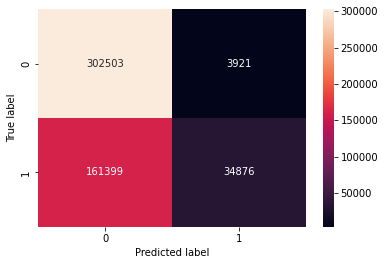

In [ ]:
from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
from pyspark.ml.evaluation import BinaryClassificationEvaluator
import seaborn as sns
actual = predictions.select('label').toPandas()
predicted = predictions.select('prediction').toPandas()

print('Accuracy score of predicted data :',accuracy_score(actual, predicted))

# precision score
print('Precision Score of predicted data :',precision_score(actual, predicted))

# recall score
print('Recall Score of predicted data :',recall_score(actual, predicted))

# F1 score
print('F1 Score of predicted data :',f1_score(actual, predicted))

cf_matrix = confusion_matrix(actual, predicted)
sns.heatmap(cf_matrix, annot=True, fmt="d")
plt.ylabel('True label')
plt.xlabel('Predicted label')

In [ ]:
from pyspark.ml.classification import DecisionTreeClassifier
dt = DecisionTreeClassifier()
dtModel = dt.fit(train)

In [ ]:
predictions = dtModel.transform(test)
predictions.select(['label', 'features', 'rawPrediction', 'probability', 'prediction']).show(10)

+-----+--------------------+-------------------+--------------------+----------+
|label|            features|      rawPrediction|         probability|prediction|
+-----+--------------------+-------------------+--------------------+----------+
|  0.0|(17,[3,5,9,10,11,...|[537292.0,283333.0]|[0.65473511043412...|       0.0|
|  0.0|(17,[3,5,9,10,11,...|[537292.0,283333.0]|[0.65473511043412...|       0.0|
|  0.0|(17,[3,5,9,10,11,...|[537292.0,283333.0]|[0.65473511043412...|       0.0|
|  0.0|(17,[3,5,9,10,11,...|[537292.0,283333.0]|[0.65473511043412...|       0.0|
|  0.0|(17,[3,5,9,10,11,...|[537292.0,283333.0]|[0.65473511043412...|       0.0|
|  0.0|(17,[3,5,9,10,11,...|[537292.0,283333.0]|[0.65473511043412...|       0.0|
|  0.0|(17,[3,5,9,10,11,...|[537292.0,283333.0]|[0.65473511043412...|       0.0|
|  0.0|(17,[3,5,9,10,11,...|[537292.0,283333.0]|[0.65473511043412...|       0.0|
|  0.0|(17,[3,5,9,10,11,...|[537292.0,283333.0]|[0.65473511043412...|       0.0|
|  0.0|(17,[3,5,9,10,11,...|

Accuracy score of predicted data : 0.669579609269165
Precision Score of predicted data : 0.7452012937409592
Recall Score of predicted data : 0.23360081518277925
F1 Score of predicted data : 0.35569933514867996


Text(0.5, 15.0, 'Predicted label')

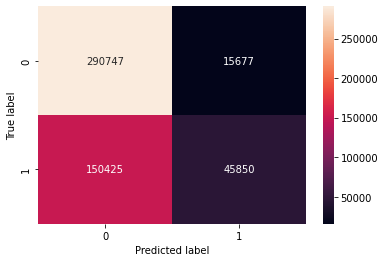

In [ ]:
actual = predictions.select('label').toPandas()
predicted = predictions.select('prediction').toPandas()

print('Accuracy score of predicted data :',accuracy_score(actual, predicted))

# precision score
print('Precision Score of predicted data :',precision_score(actual, predicted))

# recall score
print('Recall Score of predicted data :',recall_score(actual, predicted))

# F1 score
print('F1 Score of predicted data :',f1_score(actual, predicted))

cf_matrix = confusion_matrix(actual, predicted)
sns.heatmap(cf_matrix, annot=True, fmt="d")
plt.ylabel('True label')
plt.xlabel('Predicted label')

## Feature Importance

In [ ]:
from itertools import chain
attrs = sorted(
    (attr["idx"], attr["name"]) for attr in (chain(*train
        .schema["features"]
        .metadata["ml_attr"]["attrs"].values())))

In [ ]:
feature_importance = [(name, rfModel.featureImportances[idx]) for idx, name in attrs if rfModel.featureImportances[idx]]
feature_importance

[('Type of Water OHE_Common bottled waters', 0.013643630424385534),
 ('Type of Water OHE_Distilled reverse osmosis wate', 0.010257623550983115),
 ('Type of Water OHE_Bottled waters labeled as alkaline', 0.02154374493195007),
 ('Type of Water OHE_Acidic water', 0.02927720404600365),
 ('Type of Water OHE_Ocean water', 0.005389077447472839),
 ('Type of Hardness OHE_Very Hard', 0.007002307166196407),
 ('Type of Hardness OHE_Hard', 0.0059218749996845935),
 ('Type of Hardness OHE_Moderately hard', 0.0049364494889832),
 ('ph', 0.1972145604938039),
 ('Hardness', 0.10753339629566107),
 ('Solids', 0.09240137265056372),
 ('Chloramines', 0.09480766042532139),
 ('Sulfate', 0.28768692852746786),
 ('Conductivity', 0.029254657632106742),
 ('Organic_carbon', 0.031199277992818467),
 ('Trihalomethanes', 0.03129710095028801),
 ('Turbidity', 0.030633132976309308)]

In [ ]:
df = pd.DataFrame(feature_importance)
# giving column names of dataframe
columns = ["feature", "importance"]

# creating a dataframe
feature_importance_df = spark.createDataFrame(df, schema=columns)
feature_importance_df.orderBy("importance", ascending=False).show(30)

+--------------------+--------------------+
|             feature|          importance|
+--------------------+--------------------+
|             Sulfate| 0.28768692852746786|
|                  ph|  0.1972145604938039|
|            Hardness| 0.10753339629566107|
|         Chloramines| 0.09480766042532139|
|              Solids| 0.09240137265056372|
|     Trihalomethanes| 0.03129710095028801|
|      Organic_carbon|0.031199277992818467|
|           Turbidity|0.030633132976309308|
|Type of Water OHE...| 0.02927720404600365|
|        Conductivity|0.029254657632106742|
|Type of Water OHE...| 0.02154374493195007|
|Type of Water OHE...|0.013643630424385534|
|Type of Water OHE...|0.010257623550983115|
|Type of Hardness ...|0.007002307166196407|
|Type of Hardness ...|0.005921874999684...|
|Type of Water OHE...|0.005389077447472839|
|Type of Hardness ...|  0.0049364494889832|
+--------------------+--------------------+



In [ ]:
feature_importance_df.toPandas().to_csv('feature.csv')